In [1]:
import sys
import pandas as pd
from pandas import read_sql_query, read_sql_table
import tables
import sqlite3
import sqlalchemy
import matplotlib.pyplot as plt

In [3]:
def read_sqlite(dbfile):
    with sqlite3.connect(dbfile) as dbcon:
        tables = list(read_sql_query("SELECT name FROM sqlite_master WHERE type='table';", dbcon)['name'])
        out = {tbl : read_sql_query(f"SELECT * from {tbl}", dbcon) for tbl in tables}
    return out

In [2]:
#Get all files
import os

#define base paths
nsys_rep_base = '../nsys_reports'
test_folders = ['varySize_test1','varySize_test2','varySize_test3']
network_sizes = ['64','128','256','512','1024'] #network input sizes

#master dataframe = dictionary of all stat files
master = {}

for folder in test_folders:
    temp_path = os.path.join(nsys_rep_base,folder,'stats')
    temp={}
    for f in os.listdir(path=os.path.join(nsys_rep_base,folder,'stats')):
        temp[str(f)] = pd.read_csv(os.path.join(nsys_rep_base,folder,'stats',f))
    master[str(folder)] = temp


In [3]:
####################################################################################
#   description     : For all variants (network/image size in this case), 
#                     load all stat files from single test
#   Args:
#       master      : master dictionary resembling the folder structure: 
#                     [root]->[ test_case_# ]->[ $(variant)_$(stat).csv ] 
#       test_no     : specify a single test case
#       variants    : img_size?
#       stat_file   : stat file name (string)
####################################################################################
def singleTest_allVariants_stats(master, test, variant_prefix, variants, stat_file):
    db = {}
    for v in variants:
        db[v] = master[test][str(variant_prefix+v+"_"+stat_file+'.csv')]
    return db



####################################################################################
#   description     : For all variants (network/image size in this case), 
#                   load all stat files from all the test cases          
#   Args:
#       master       : master dictionary resembling the folder structure: 
#                      [root]->[ test_case_# ]->[ $(variant)_$(stat).csv ] 
#       test_no      : specify a single test case
#       variants     : img_size?
#       stat_file   : stat file name (string)
####################################################################################
def allTests_allVariants_stats(master, tests, variant_prefix, variants, stat_file):
    file_ext  = '.csv'
    db = {}
    temp = {}

    for test_no in tests:
        for v in variants:
            temp[v] = master[test_no][str(variant_prefix+v+"_"+stat_file+file_ext)]
        db[test_no] = temp
    return db


####################################################################################
#   description     : add suffix to all the columns of a dataframe         
#   Args:
#       df          : dataframe  
#       sfx         : suffix
####################################################################################
# 
def add_suffix(df,sfx, ignore):
    df.columns = df.columns.map(lambda x: str(x) if x == ignore else (str(x) + sfx))


In [6]:
master.keys()

dict_keys(['varySize_test1', 'varySize_test2', 'varySize_test3'])

In [7]:
# stats for "cuda api summary"
#NOTE: cuda_api_sum is erroneous!
#cuda_api_sum             = singleTest_allVariants_stats(master=master, test = 'varySize_test1', variant_prefix='size_', variants=network_sizes, stat_file='cuda_api_sum')
cuda_api_sum             = allTests_allVariants_stats(master=master,   tests= master.keys(),    variant_prefix='size_', variants=network_sizes, stat_file='cuda_api_sum')
#cuda_gpu_mem_size_sum   = singleTest_allVariants_stats(master=master, test = 'varySize_test1', variants=network_sizes, stat_file='cuda_gpu_mem_size_sum')
#nvtx_sum                = singleTest_allVariants_stats(master=master, test = 'varySize_test1', variants=network_sizes, stat_file='nvtx_sum')
#cuda_gpu_mem_time_sum   = singleTest_allVariants_stats(master=master, test = 'varySize_test1', variants=network_sizes, stat_file='cuda_gpu_mem_time_sum')


In [8]:
cas_avg = {}
for sz in network_sizes:
    cas_avg[sz] = pd.concat([cuda_api_sum['varySize_test1'][sz], cuda_api_sum['varySize_test2'][sz], cuda_api_sum['varySize_test3'][sz]]).groupby('Name', as_index=False).mean()

In [9]:
cas_list = ['cas_64','cas_128','cas_256','cas_512','cas_1024']
cas = {}
    
for sz in network_sizes:
    cas[sz] = cas_avg[sz][['Time (%)','Num Calls','Total Time (ns)','Name']]
    #print(cas[sz]['Num Calls'].loc[(cas[sz]['Name'])=='cudaStreamIsCapturing_v10000'])
    cas[sz] = cas[sz].set_index('Name')
    add_suffix(cas[sz],str('_sz'+sz), ignore='Name')

In [10]:
#NOTE: cas_all is erroneous
cas_all = cas['64'].join(cas['128'], on='Name')
cas_all = cas_all.join(cas['256'])
cas_all = cas_all.join(cas['512'])
cas_all = cas_all.join(cas['1024'])
cas_all.reset_index(inplace=True)

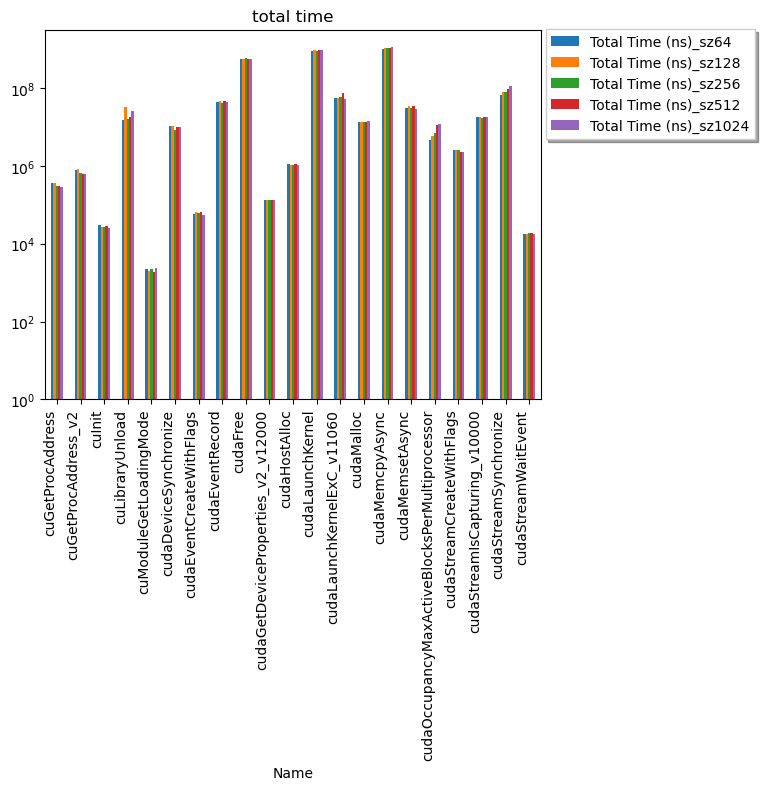

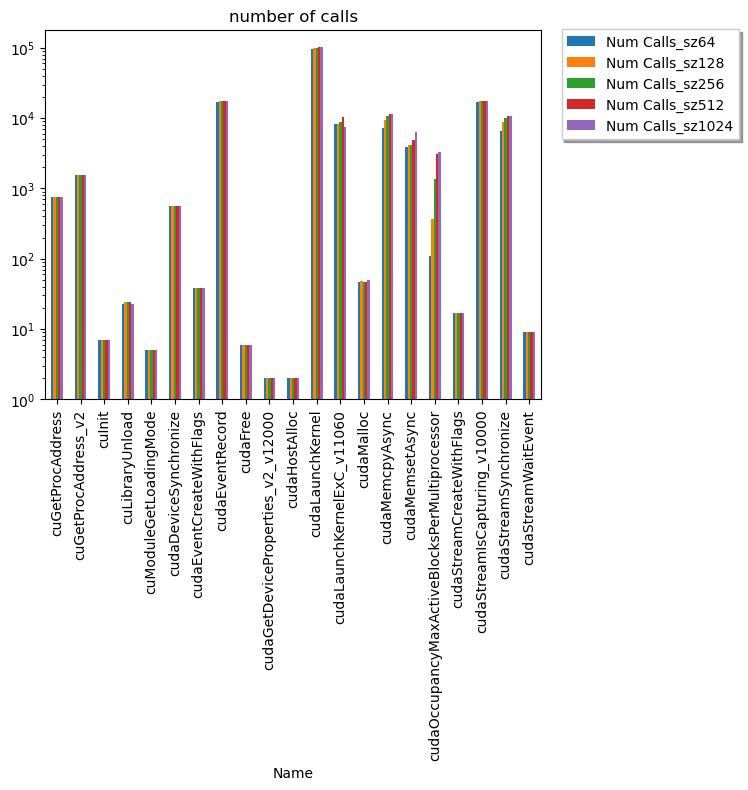

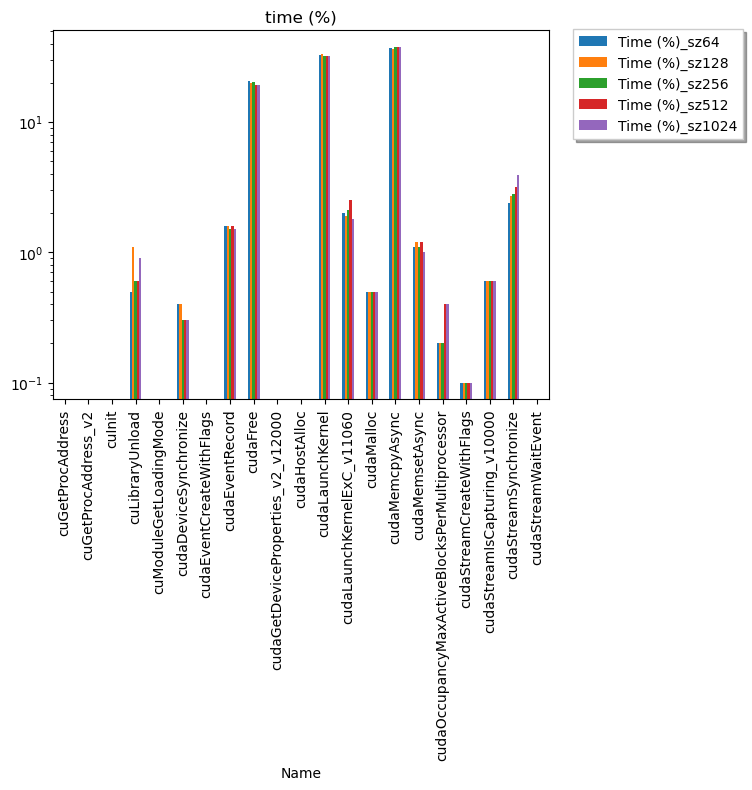

In [11]:
cas_tot_time = cas_all[['Name',
'Total Time (ns)_sz64',
'Total Time (ns)_sz128',
'Total Time (ns)_sz256',
'Total Time (ns)_sz512',
'Total Time (ns)_sz1024']]

cas_time_perct = cas_all[['Name',
'Time (%)_sz64',
'Time (%)_sz128',
'Time (%)_sz256',
'Time (%)_sz512',
'Time (%)_sz1024']]

cas_num_calls = cas_all[['Name',
'Num Calls_sz64',
'Num Calls_sz128',
'Num Calls_sz256',
'Num Calls_sz512',
'Num Calls_sz1024']]


ax = cas_tot_time.plot(kind='bar',x='Name', title='total time',log=True)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right');
ax.legend(loc='upper center', bbox_to_anchor=(1.22, 1.02), ncol=1, fancybox=False, shadow=True)

ax1 = cas_num_calls.plot(kind='bar',x='Name', title='number of calls',log=True)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right');
ax1.legend(loc='upper center', bbox_to_anchor=(1.22, 1.02), ncol=1, fancybox=False, shadow=True)

ax2 = cas_time_perct.plot(kind='bar',x='Name', title='time (%)',log=True)
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right');
ax2.legend(loc='upper center', bbox_to_anchor=(1.22, 1.02), ncol=1, fancybox=False, shadow=True)

fig = ax.get_figure()
fig.savefig('figures/cas_total_time.jpg',bbox_inches='tight')
fig = ax.get_figure()
fig.savefig('figures/cas_num_of_calls.jpg',bbox_inches='tight')
fig = ax.get_figure()
fig.savefig('figures/cas_percent.jpg',bbox_inches='tight')

In [12]:
master['varySize_test1'].keys()

dict_keys(['size_64_nvtx_sum.csv', 'size_64_osrt_sum.csv', 'size_64_cuda_api_sum.csv', 'size_64_cuda_gpu_kern_sum.csv', 'size_64_cuda_gpu_mem_time_sum.csv', 'size_64_cuda_gpu_mem_size_sum.csv', 'size_128_nvtx_sum.csv', 'size_128_osrt_sum.csv', 'size_128_cuda_api_sum.csv', 'size_128_cuda_gpu_kern_sum.csv', 'size_128_cuda_gpu_mem_time_sum.csv', 'size_128_cuda_gpu_mem_size_sum.csv', 'size_256_nvtx_sum.csv', 'size_256_osrt_sum.csv', 'size_256_cuda_api_sum.csv', 'size_256_cuda_gpu_kern_sum.csv', 'size_256_cuda_gpu_mem_time_sum.csv', 'size_256_cuda_gpu_mem_size_sum.csv', 'size_512_nvtx_sum.csv', 'size_512_osrt_sum.csv', 'size_512_cuda_api_sum.csv', 'size_512_cuda_gpu_kern_sum.csv', 'size_512_cuda_gpu_mem_time_sum.csv', 'size_512_cuda_gpu_mem_size_sum.csv', 'size_1024_nvtx_sum.csv', 'size_1024_osrt_sum.csv', 'size_1024_cuda_api_sum.csv', 'size_1024_cuda_gpu_kern_sum.csv', 'size_1024_cuda_gpu_mem_time_sum.csv', 'size_1024_cuda_gpu_mem_size_sum.csv'])

In [13]:
nvtx_sum = allTests_allVariants_stats(master=master, tests=master.keys(), variant_prefix='size_', variants= network_sizes , stat_file='nvtx_sum')
nvtx = {}
for sz in network_sizes:
    nvtx[sz] = pd.concat([nvtx_sum['varySize_test1'][sz], nvtx_sum['varySize_test2'][sz], nvtx_sum['varySize_test3'][sz]]).groupby('Range', as_index=False).mean()
    add_suffix(nvtx[sz],str('_sz'+sz), ignore = 'Range')

In [14]:
##########################################
col = 'Avg (ns)'

foo = pd.concat([
    nvtx['64'][['Range',    col+'_sz64']],
    nvtx['128'][            col+'_sz128'],
    nvtx['256'][            col+'_sz256'],
    nvtx['512'][            col+'_sz512'],
    nvtx['1024'][           col+'_sz1024']
    ],axis=1)

<H1> Combined stats from all the frame-inferences


In [137]:
#Get all files
import os

#define base paths
nsys_rep_base = '../nsys_reports/vst2'
test_folders = ['test1','test2','test3']
network_sizes = ['64','128','256','512','1024'] #network input sizes

#master dataframe = dictionary of all stat files
master = {}

for folder in test_folders:
    temp_path = os.path.join(nsys_rep_base,folder,'stats')
    temp={}
    for f in os.listdir(path=os.path.join(nsys_rep_base,folder,'stats')):
        temp[str(f)] = pd.read_csv(os.path.join(nsys_rep_base,folder,'stats',f))
    master[str(folder)] = temp


In [138]:
def get_avg_of_all_tests(src, tests= master.keys(), variants=network_sizes, grpByVal='Name'):
    avg = {}
    for v in variants:
        avg[v] = pd.DataFrame()
        for test in tests:
            avg[v] = pd.concat([avg[v],src[test][v]])
        avg[v] = avg[v].groupby(grpByVal,as_index=False).mean()
    return avg

def get_single_metric_all_variants(src=None, x='Time',  y=None, variants=network_sizes):
    data = src[variants[0]][[x]]
    for v in variants:
        add_suffix(src[v], str('_'+v), ignore=x)
        data = pd.concat([data, src[v][[str(y+'_'+v)]]], axis=1)
    return data

In [139]:
nvtx_sum = allTests_allVariants_stats(master=master,   tests= master.keys(),    variant_prefix='size_', variants=network_sizes, stat_file='nvtx_sum')
nvtx_avg = get_avg_of_all_tests(src=nvtx_sum, tests=master.keys(), variants=network_sizes, grpByVal='Range')
nvtx_total_time = get_single_metric_all_variants(nvtx_avg, x='Range', y='Total Time (ns)')


In [134]:
#nvtx_avg = {}
#for sz in network_sizes:
#    nvtx_avg[sz] = pd.concat([nvtx_sum['test1'][sz], nvtx_sum['test2'][sz], nvtx_sum['test3'][sz]]).groupby('Range', as_index=False).mean()

In [50]:
#nvtx_list = ['nvtx_64','nvtx_128','nvtx_256','nvtx_512','nvtx_1024']
#nvtx = {}
#    
#for sz in network_sizes:
#    nvtx[sz] = nvtx_avg[sz][['Time (%)','Total Time (ns)','Instances','Avg (ns)','Med (ns)','Range']]
#    nvtx[sz] = nvtx[sz].set_index('Range')
#    add_suffix(nvtx[sz],str('_sz'+sz), ignore='Range')
#    nvtx[sz].reset_index(inplace=True)

In [140]:
nvtx_avg['64'].columns

Index(['Range', 'Time (%)_64', 'Total Time (ns)_64', 'Instances_64',
       'Avg (ns)_64', 'Med (ns)_64', 'Min (ns)_64', 'Max (ns)_64',
       'StdDev (ns)_64'],
      dtype='object')

In [120]:
##########################################
#col = 'Total Time (ns)'
#
#nvtx_tot_time = pd.concat([
#    nvtx['64'][['Range',    col+'_sz64']],
#    nvtx['128'][            col+'_sz128'],
#    nvtx['256'][            col+'_sz256'],
#    nvtx['512'][            col+'_sz512'],
#    nvtx['1024'][           col+'_sz1024']
#    ],axis=1)
#nvtx_tot_time

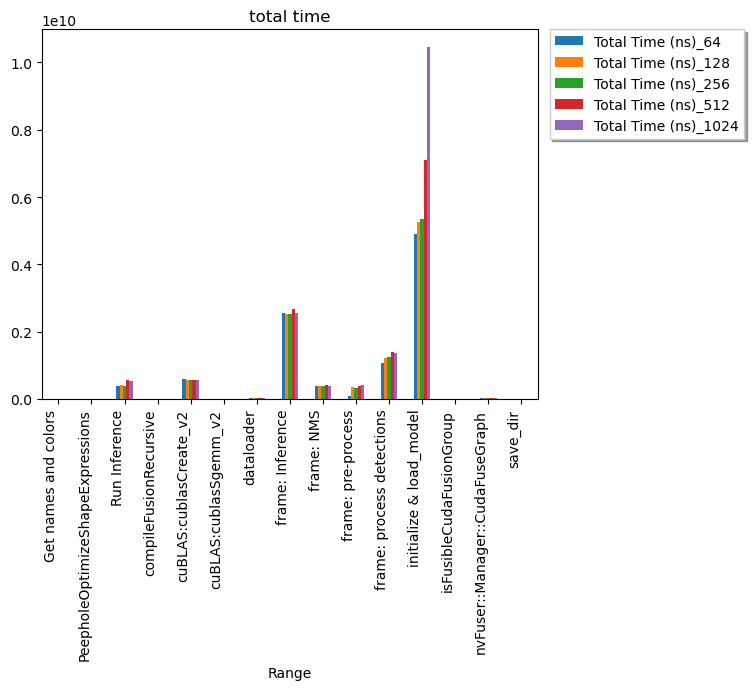

In [141]:
ax = nvtx_total_time.plot(kind='bar',x='Range', title='total time')
plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right');
ax.legend(loc='upper center', bbox_to_anchor=(1.22, 1.02), ncol=1, fancybox=False, shadow=True)

#ax1 = cas_num_calls.plot(kind='bar',x='Name', title='number of calls',log=True)
#plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right');
#ax1.legend(loc='upper center', bbox_to_anchor=(1.22, 1.02), ncol=1, fancybox=False, shadow=True)
#
#ax2 = cas_time_perct.plot(kind='bar',x='Name', title='time (%)',log=True)
#plt.setp(ax.get_xticklabels(), rotation=90, horizontalalignment='right');
#ax2.legend(loc='upper center', bbox_to_anchor=(1.22, 1.02), ncol=1, fancybox=False, shadow=True)
#
fig = ax.get_figure()
fig.savefig('figures/nvtx_vst2_tot_time.jpg',bbox_inches='tight')
fig = ax.get_figure()
#fig.savefig('figures/cas_num_of_calls.jpg',bbox_inches='tight')
#fig = ax.get_figure()
#fig.savefig('figures/cas_percent.jpg',bbox_inches='tight')

<H2> Test3 </H2>